**Image Caption Generation**

import the required libraries


In [1]:

import re
import string
import os
import cv2
import json
import tqdm
import random
import einops
import pathlib
import collections
import numpy as np
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import random as python_random

from nltk.translate.bleu_score import sentence_bleu


In [2]:
# setting up the random seed for reproducability 
seed_value = 42
def reset_seeds(seed_value):
   np.random.seed(seed_value)
   python_random.seed(seed_value)
   tf.random.set_seed(seed_value)
reset_seeds(seed_value)

**create_dataset** function reads the COCO captions json files and creates a 'captions' dictionary with image file name and captions as key, value pairs (captions are initiated as list of captions).

then the image file name and capitions are flattened to make 1:1 pair and finally converted to tensorflow Dataset object

In [3]:
def create_dataset(annotations_path, data_type='train'):
    captions = {}
    file_name = 'captions_{}2014.json'.format(data_type)
    with open(annotations_path + file_name, 'r') as f:
        captions_json = json.load(f)
    for annotation in captions_json["annotations"]:
        image_id = annotation['image_id'] 
        image_filename = 'COCO_{}2014_{:012d}.jpg'.format(data_type,image_id)
        image_file_path = './{}2014/'.format(data_type) + image_filename
        caption = annotation['caption']
        if image_file_path not in captions:
            captions[image_file_path] = [caption]
        else:
            captions[image_file_path].append(caption)
    image_file_paths = []
    caption_lists = []
    for image_file_path, caption_list in captions.items():
        if len(caption_list) == 5:
            image_file_paths.extend([image_file_path] * len(caption_list))
            caption_lists.extend(caption_list)
        else:
            continue
    flattened_tensor = (tf.constant(image_file_paths), tf.constant(caption_lists))
    dataset = tf.data.Dataset.from_tensor_slices(flattened_tensor)

    return dataset


creating train and validation datasets

In [4]:
annotations_path = './annotations/'
train_data = create_dataset(annotations_path, 'train')
val_data = create_dataset(annotations_path, 'val')


In [5]:
# Shuffle the dataset
# train_data = train_data.shuffle(buffer_size=10).take(70000)
# val_data = val_data.shuffle(buffer_size=10).take(7000)
train_data = train_data.take(70000)
val_data = val_data.take(7000)


inspecting the data

In [6]:
for ex_path, ex_captions in train_data.take(5):
   print(ex_path, ex_captions
        )

tf.Tensor(b'./train2014/COCO_train2014_000000318556.jpg', shape=(), dtype=string) tf.Tensor(b'A very clean and well decorated empty bathroom', shape=(), dtype=string)
tf.Tensor(b'./train2014/COCO_train2014_000000318556.jpg', shape=(), dtype=string) tf.Tensor(b'A blue and white bathroom with butterfly themed wall tiles.', shape=(), dtype=string)
tf.Tensor(b'./train2014/COCO_train2014_000000318556.jpg', shape=(), dtype=string) tf.Tensor(b'A bathroom with a border of butterflies and blue paint on the walls above it.', shape=(), dtype=string)
tf.Tensor(b'./train2014/COCO_train2014_000000318556.jpg', shape=(), dtype=string) tf.Tensor(b'An angled view of a beautifully decorated bathroom.', shape=(), dtype=string)
tf.Tensor(b'./train2014/COCO_train2014_000000318556.jpg', shape=(), dtype=string) tf.Tensor(b'A clock that blends in with the wall hangs in a bathroom. ', shape=(), dtype=string)


In [7]:

for ex_path, ex_captions in val_data.take(5):
  print(ex_path, ex_captions)

tf.Tensor(b'./val2014/COCO_val2014_000000203564.jpg', shape=(), dtype=string) tf.Tensor(b'A bicycle replica with a clock as the front wheel.', shape=(), dtype=string)
tf.Tensor(b'./val2014/COCO_val2014_000000203564.jpg', shape=(), dtype=string) tf.Tensor(b'The bike has a clock as a tire.', shape=(), dtype=string)
tf.Tensor(b'./val2014/COCO_val2014_000000203564.jpg', shape=(), dtype=string) tf.Tensor(b'A black metal bicycle with a clock inside the front wheel.', shape=(), dtype=string)
tf.Tensor(b'./val2014/COCO_val2014_000000203564.jpg', shape=(), dtype=string) tf.Tensor(b'A bicycle figurine in which the front wheel is replaced with a clock\n', shape=(), dtype=string)
tf.Tensor(b'./val2014/COCO_val2014_000000203564.jpg', shape=(), dtype=string) tf.Tensor(b'A clock with the appearance of the wheel of a bicycle ', shape=(), dtype=string)


**Standardizer** function for Tokenizer to convert the text to lower case followed by replacing puntuations with empty string and then adding START and END tokens at beginning and end of the Sentences

In [8]:
def standardizer(caption):
  caption = tf.strings.lower(caption)
  caption = tf.strings.regex_replace(caption, f'[{re.escape(string.punctuation)}]', '')
  caption = tf.strings.join(['[START]', caption, '[END]'], separator=' ')
  return caption

Initializing TextVectorization layer of keras library as tokenizer

In [9]:
# Use the 6000 most frequent words for a vocabulary.
vocabulary_size = 6000 # was 1000 

tokenizer = tf.keras.layers.TextVectorization(
    vocabulary_size=vocabulary_size,
    split='whitespace',
    standardize=standardizer,
    ragged=True)
# Learn the vocabulary from the caption data.

Performing Tokenization of training data  with a tokenization batch size of 256

In [10]:
batch = 256
tokenizer.adapt(train_data.map(lambda fp, txt: tf.expand_dims(txt, 0)).unbatch().batch(batch))
print("first 10 most frequent words in train_dataset vocabalary",tokenizer.get_vocabulary()[:10])



first 10 most frequent words in train_dataset vocabalary ['', '[UNK]', 'a', '[START]', '[END]', 'the', 'on', 'in', 'of', 'with']


In [11]:
tokenizer([['a girl standing on a a building a']])  # an example of tokenizer output

<tf.RaggedTensor [[3, 2, 157, 29, 6, 2, 2, 68, 2, 4]]>

Loading and Instantiating the **MobileNetV3Small architecturì** as the **Feature extractor** for the model.

MobileNetV3Small is a pretrained model on Imagenet which has 1000 classes.

MobileNetV3Small has 2.9 million parameters and 68.1 top 1 accuracy trained over 

The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  

In [12]:
IMAGE_SHAPE=(320, 320, 3)  # takeing bigger image input for more details rather than original 224
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

Instantiating the **ResNet50** pretrained model on imagenet dataset.
ResNet 50 has better performance than MobileNet but computationally expensive 
The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  

In [13]:
# For experimental purpose but not used in the final results
resnet = tf.keras.applications.ResNet50(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet'
)
resnet.trainable = False

To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [14]:
def split_tokens(imgs, txts):
    tokens = tokenizer(txts)
    input_tokens = tokens[..., :-1]
    label_tokens = tokens[..., 1:]
    return (imgs, input_tokens), label_tokens

In [15]:
def preprocess_image(file_name):

    img = tf.io.read_file(file_name)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img



In [16]:
test_img_batch = preprocess_image((ex_path.numpy().decode("utf-8")))[tf.newaxis, :]
# print(test_img_batch.shape)
# print(mobilenet(test_img_batch).shape)

In [17]:
def prepare_dataset(ds, batch_size=64, shuffle_buffer=1000): # was 32
  # Load the images and make batches.
  def map_fn(file_name, caption):
        return preprocess_image(file_name), caption
  ds = (ds
        .shuffle(10000)
        .map(map_fn)
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(split_tokens, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [18]:
train_ds = prepare_dataset(train_data)
train_ds.element_spec

((TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [19]:
val_ds = prepare_dataset(val_data)
train_ds.element_spec

((TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### Building the **Transformer Encoder-Decoder**(2 layer) model

**Input** is a seqembedding module for token embedding and positional encoding


In [20]:
class SeqEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, max_length, units):
        super().__init__()
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=units)
        self.token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                         output_dim=units,
                                                         mask_zero=True)
        self.add = tf.keras.layers.Add()
    
    def call(self, s):
        s = self.token_embedding(s)
        x = tf.range(tf.shape(s)[1])
        x = x[tf.newaxis, :]
        x = self.pos_embedding(x)
        return self.add([s,x])
    

***Decoder***

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

A causal self attention layer (`CausalSelfAttention`), where each output location can attend to the output so far.


In [21]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.multi_head_attn = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        attn = self.multi_head_attn(query=x, value=x, use_causal_mask=True)
        x = self.add( [x, attn] )
        return self.layernorm(x)

The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

 A cross attention layer (`CrossAttention`) where each output location can attend to the input image.

In [22]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.multi_head_attn = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x, y, **kwargs):
        attn, attn_scores = self.multi_head_attn(query=x,
                                                 value=y,
                                                 return_attention_scores=True)
        self.last_attention_scores = attn_scores
        x = self.add([x, attn])
        return self.layernorm(x)
    

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

A feed forward network (`FeedForward`) layer which further processes each output location independently.

In [23]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate = 0.2):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(units=2*units, activation='relu'),
            tf.keras.layers.Dense(units=units),
            tf.keras.layers.Dropout(rate=dropout_rate),
        ])
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        
        x = x + self.seq(x)
        return self.layernorm(x)
    

arranging all the 3 layers to form a DecoderLayer.

Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.


In [24]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=1, dropout_rate=0.2):
        super().__init__()

        self.self_attn = SelfAttention(num_heads=num_heads,
                                             key_dim=units,
                                             dropout=dropout_rate)
        
        self.cross_attn = CrossAttention(num_heads=2*num_heads,   # 2*n heads experiment
                                             key_dim=units,
                                             dropout=dropout_rate)
        self.ff = FeedForward(units=units,dropout_rate=dropout_rate)

    def call(self, inputs, training=False):
        input_seq, out_seq = inputs
        out_seq = self.self_attn(out_seq)
        out_seq = self.cross_attn(out_seq, input_seq)
        self.last_attention_scores = self.cross_attn.last_attention_scores
        out_seq = self.ff(out_seq)
        return out_seq
        

***Output - A multiclass-classification over the output vocabulary.***

In [25]:

class TokenOutput(tf.keras.layers.Layer):
    def __init__(self, tokenizer, banned_tokens=('','[UNK]','[START]'), **kwargs):
        super().__init__()
        self.dense = tf.keras.layers.Dense(units=tokenizer.vocabulary_size(), 
                                           **kwargs)
        self.tokenizer = tokenizer
        self.banned_tokens = banned_tokens
        self.bias = None

    def adapt(self, ds):
        counts = collections.Counter()
        vocab_dict = {name:id for id, name in enumerate(self.tokenizer.get_vocabulary())}
        
        # count the occurances of each word in the vocabulary
        for tokens in tqdm.tqdm(ds):
            counts.update(tokens.numpy().flatten())
        
        # create a count array with the recordded counts and make a word and its count pair
        counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
        counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())
        counts_arr = counts_arr[:] # creating a shallow copy
        
        # set the count of banned tokens to 0
        for token in self.banned_tokens:
            counts_arr[vocab_dict[token]] = 0
        
        # get the probability distribution and entropy
        total = counts_arr.sum()
        p = counts_arr/total
        p[counts_arr==0] = 1.0
        log_p = np.log(p)
        entropy = -(log_p*p).sum()

        print()
        print(f'Uniform entropy : {np.log(self.tokenizer.vocabulary_size()):0.2f}')
        print(f'Marginal entropy : {entropy:0.2f}')

        # set the bias with log of probability and bias of banned elements to a big negative value to ignore them in prediction
        self.bias = log_p
        self.bias[counts_arr==0] = -1e9

    def call(self, x):
        x = self.dense(x)
        return x + self.bias
    

In [26]:
output_layer = TokenOutput(tokenizer=tokenizer,
                           banned_tokens=('','[UNK]','[START]'))


In [27]:
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

1094it [01:47, 10.17it/s]


Uniform entropy : 9.28
Marginal entropy : 5.29


***Combining above all and building the Model***

1. The image `feature_extractor` and the text `tokenizer`.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.

In [28]:
class CaptionGenerator(tf.keras.Model):
    def __init__(self, tokenizer, feature_extractor, output_layer,
                  num_layers=1, units=512, max_length=25,  # 50
                  num_heads=1, dropout_rate=0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.index_to_word = tf.keras.layers.StringLookup(
            mask_token='',
            vocabulary=tokenizer.get_vocabulary(),
            invert=True
        )
        self.word_to_index = tf.keras.layers.StringLookup(
            mask_token='',
            vocabulary= tokenizer.get_vocabulary()
        )
        self.seq_embedding = SeqEmbedding(vocab_size=tokenizer.vocabulary_size(),
                                          units=units, max_length=max_length)
        self.decoder_layers = [DecoderLayer(units=units, num_heads=num_heads,
                                           dropout_rate=dropout_rate)
                                           for n in range(num_layers)]
        self.output_layer = output_layer

    def inference(self, image, temperature=1):
        initial = self.word_to_index([['START']])
        img_features = self.feature_extractor(image[tf.newaxis, ...])
        tokens = initial
        for n in range(50):
            
            preds = self((img_features, tokens)).numpy()
            preds = preds[:, -1, :]
            if temperature == 0:
                next = tf.argmax(preds, axis=-1)[:, tf.newaxis]
            else:
                next = tf.random.categorical(preds/temperature, num_samples=1)
            tokens = tf.concat([tokens, next], axis=1)
            if next[0] == self.word_to_index('[END]'):
                break
        words = self.index_to_word(tokens[0,1:-1])
        result_string = words.numpy()
        result_string = [item.decode('utf-8') for item in result_string]
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        return result.numpy().decode(), result_string


    def call(self, inputs):
        img, txt = inputs
        b, h, w, c = img.shape
        if c == 3:
            img = self.feature_extractor(img)
        img = einops.rearrange(img, 'b h w c -> b (h w) c')
        if txt.dtype == tf.string:
            txt = self.tokenizer(txt)
        txt = self.seq_embedding(txt)
        for decoder_layer  in self.decoder_layers:
            txt = decoder_layer(inputs=(img, txt))
        txt = self.output_layer(txt)
        return txt

In [29]:
model = CaptionGenerator(tokenizer=tokenizer, feature_extractor=mobilenet,
                         output_layer=output_layer, units=256, dropout_rate=0.25,
                         num_heads=2, num_layers=2)


### Losses and Metrics

In [31]:
def masked_loss(labels, predictions):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, predictions)
    mask = (labels !=0) & (loss < 1e8)
    mask = tf.cast(mask, loss.dtype)
    loss = loss*mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_acc(labels, predictions):
    mask = tf.cast(labels!=0, tf.float32)
    predictions = tf.argmax(predictions, axis=-1)
    labels = tf.cast(labels, tf.int64)
    match = tf.cast(predictions == labels, mask.dtype)
    accuracy = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
    return accuracy


In [32]:
def lr_scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    lr = lr * 0.9
    return lr

In [33]:
from keras.callbacks import ModelCheckpoint

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler) 
checkpoint = ModelCheckpoint('model_best_val_2n.tf', monitor='val_loss', save_best_only=True, mode='min', save_freq='epoch')



### Training

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=masked_loss,
              metrics=[masked_acc],
              run_eagerly=False)

In [35]:
import warnings

# Filter out UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
# Your code here

# Reset warning filters (optional)
warnings.resetwarnings()

In [36]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, 
    callbacks=[learning_rate_scheduler, checkpoint])

Epoch 1/30


C:\Users\asifk\anaconda3\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


   1094/Unknown - 168s 138ms/step - loss: 3.8417 - masked_acc: 0.3658

1094/1094 [==============================] - 197s 165ms/step - loss: 3.8417 - masked_acc: 0.3658 - val_loss: 3.4769 - val_masked_acc: 0.3959 - lr: 1.0000e-04
Epoch 2/30
1094/1094 [==============================] - ETA: 0s - loss: 3.1886 - masked_acc: 0.4244

1094/1094 [==============================] - 179s 162ms/step - loss: 3.1886 - masked_acc: 0.4244 - val_loss: 3.1577 - val_masked_acc: 0.4213 - lr: 1.0000e-04
Epoch 3/30
1094/1094 [==============================] - ETA: 0s - loss: 2.9203 - masked_acc: 0.4471

1094/1094 [==============================] - 180s 163ms/step - loss: 2.9203 - masked_acc: 0.4471 - val_loss: 3.0026 - val_masked_acc: 0.4316 - lr: 1.0000e-04
Epoch 4/30
1094/1094 [==============================] - ETA: 0s - loss: 2.7481 - masked_acc: 0.4626

1094/1094 [==============================] - 204s 186ms/step - loss: 2.7481 - masked_acc: 0.4626 - val_loss: 2.9147 - val_masked_acc: 0.4390 - lr: 1.0000e-04
Epoch 5/30
1094/1094 [==============================] - ETA: 0s - loss: 2.6180 - masked_acc: 0.4748

1094/1094 [==============================] - 204s 185ms/step - loss: 2.6180 - masked_acc: 0.4748 - val_loss: 2.8560 - val_masked_acc: 0.4426 - lr: 1.0000e-04
Epoch 6/30
1094/1094 [==============================] - ETA: 0s - loss: 2.5111 - masked_acc: 0.4849

1094/1094 [==============================] - 211s 191ms/step - loss: 2.5111 - masked_acc: 0.4849 - val_loss: 2.8244 - val_masked_acc: 0.4474 - lr: 1.0000e-04
Epoch 7/30
1094/1094 [==============================] - ETA: 0s - loss: 2.4181 - masked_acc: 0.4947

1094/1094 [==============================] - 208s 188ms/step - loss: 2.4181 - masked_acc: 0.4947 - val_loss: 2.8005 - val_masked_acc: 0.4466 - lr: 1.0000e-04
Epoch 8/30
1094/1094 [==============================] - ETA: 0s - loss: 2.3343 - masked_acc: 0.5033

1094/1094 [==============================] - 203s 184ms/step - loss: 2.3343 - masked_acc: 0.5033 - val_loss: 2.7857 - val_masked_acc: 0.4489 - lr: 1.0000e-04
Epoch 9/30
1094/1094 [==============================] - ETA: 0s - loss: 2.2579 - masked_acc: 0.5111

1094/1094 [==============================] - 204s 185ms/step - loss: 2.2579 - masked_acc: 0.5111 - val_loss: 2.7784 - val_masked_acc: 0.4484 - lr: 1.0000e-04
Epoch 10/30
1094/1094 [==============================] - 173s 157ms/step - loss: 2.1863 - masked_acc: 0.5198 - val_loss: 2.7818 - val_masked_acc: 0.4486 - lr: 1.0000e-04
Epoch 11/30
1094/1094 [==============================] - 176s 160ms/step - loss: 2.1097 - masked_acc: 0.5292 - val_loss: 2.7925 - val_masked_acc: 0.4485 - lr: 9.0000e-05
Epoch 12/30
1094/1094 [==============================] - 174s 158ms/step - loss: 2.0426 - masked_acc: 0.5382 - val_loss: 2.7939 - val_masked_acc: 0.4486 - lr: 8.1000e-05
Epoch 13/30
1094/1094 [==============================] - 173s 157ms/step - loss: 1.9803 - masked_acc: 0.5465 - val_loss: 2.8100 - val_masked_acc: 0.4474 - lr: 7.2900e-05
Epoch 14/30
1094/1094 [==============================] - 173s 157ms/step - loss: 1.9245 - masked_acc: 0.5548 - val_loss: 2.8283 - val_masked_acc: 0.4477 - lr: 6.5

mobilenet  ---> 
 n heads::
Total params: 9,756,541
Trainable params: 8,817,421
Non-trainable params: 939,120

 2n heads ::
Total params: 11,463,549
Trainable params: 10,524,429
Non-trainable params: 939,120

resnet  ----> 39 million parameters

In [45]:
model.summary()

Model: "caption_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 10, 10, 576)      939120    
 l)                                                              
                                                                 
 text_vectorization (TextVec  multiple                 0         
 torization)                                                     
                                                                 
 string_lookup_1 (StringLook  multiple                 0         
 up)                                                             
                                                                 
 string_lookup_2 (StringLook  multiple                 0         
 up)                                                             
                                                                 
 seq_embedding (SeqEmbedding  multiple           

In [30]:
model.load_weights("C:\\Users\\asifk\\Documents\\NLP\\COCO\\model_best_val_n.tf")  # loading the saved best validation model weight for evaluation purpose

**BLEU SCORE:**  A metric that measures the precision of n-grams (sequences of words) between the generated and reference captions.

**test_and_evaluate** function takes in the number of test images to be used from validation data set then preprocess the image. It calculates the BLEU 1-gram, 2-gram, 3-gram, 4-gram scores from the predictions of the pre processed images and displayes the scores. It return the images list and predictions list to plot the predictions

In [62]:
def test_and_evaluate(test_images_count):
  counter = 0
  test_images = []
  test_captions = []
  predictions_string = []
  predictions_list = []
  imgs_list = []
  bleu_1 = []
  bleu_2 = []
  bleu_3 = []
  bleu_4 = []

  for ex_path, ex_captions in val_data.take(test_images_count*5):
    counter = counter +1
    if counter % 5 == 0: # one image for every 5 captions
      test_img = preprocess_image((ex_path.numpy().decode("utf-8")))[tf.newaxis, :]
      test_images.append(tf.squeeze(test_img))
    caption = ex_captions.numpy().decode("utf-8").split()
    test_captions.append(caption)

  for image in test_images:
      prediction, prediction_string = model.inference(image, temperature=0)
      img = image / 255.0
      predictions_list.append(prediction)
      predictions_string.append(prediction_string)
      imgs_list.append(img)

  for i in range(0,len(predictions_string)):
    score = 0
    y_pred = predictions_string[i]
    y_true = test_captions[i*5 : (i+1)*5]
    print(f"Image {i+1} BLEU scores: ")
    score = sentence_bleu(y_true, y_pred, weights=(1.0,0,0,0))
    bleu_1.append(score)
    print(f"BLEU-1 score: {score}")
    score = sentence_bleu(y_true, y_pred, weights=(0.5,0.5,0,0))
    bleu_2.append(score)
    print(f"BLEU-2 score: {score}")
    score = sentence_bleu(y_true, y_pred, weights=(0.3,0.3,0.3,0))
    bleu_3.append(score)
    print(f"BLEU-3 score: {score}")
    score = sentence_bleu(y_true, y_pred, weights=(0.25,0.25,0.25,0.25))
    bleu_4.append(score)
    print(f"BLEU-4 score: {score}")
  print(f' Average BLEU 1 : {np.mean(bleu_1)} \t Average BLEU 2 :{np.mean(bleu_2)}\t Average BLEU 3 :{np.mean(bleu_3)}\t Average BLEU 4 :{np.mean(bleu_4)}')
  return imgs_list, predictions_list

Image 1 BLEU scores: 
BLEU-1 score: 0.46002220731466165
BLEU-2 score: 0.19615412827794998
BLEU-3 score: 1.8419817303850456e-93
BLEU-4 score: 6.336877893084566e-155
Image 2 BLEU scores: 
BLEU-1 score: 0.6618726769384466
BLEU-2 score: 0.2888649183327127
BLEU-3 score: 2.2851014516106605e-93
BLEU-4 score: 7.5314086239343e-155
Image 3 BLEU scores: 
BLEU-1 score: 0.7
BLEU-2 score: 0.2788866755113585
BLEU-3 score: 2.3521227831276624e-93
BLEU-4 score: 7.877458036488388e-155
Image 4 BLEU scores: 
BLEU-1 score: 0.5454545454545454
BLEU-2 score: 0.2335496832484569
BLEU-3 score: 2.114613005848062e-93
BLEU-4 score: 7.208781414766327e-155
Image 5 BLEU scores: 
BLEU-1 score: 0.10000000000000002
BLEU-2 score: 4.717068855239749e-155
BLEU-3 score: 1.2835318765197405e-185
BLEU-4 score: 1.0244914152188952e-231
Image 6 BLEU scores: 
BLEU-1 score: 0.3
BLEU-2 score: 8.170202920075766e-155
BLEU-3 score: 1.7846088208682725e-185
BLEU-4 score: 1.3483065280626046e-231
 Average BLEU 1 : 0.46122490495127555 	 Averag

c:\Users\asifk\Documents\NLP\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


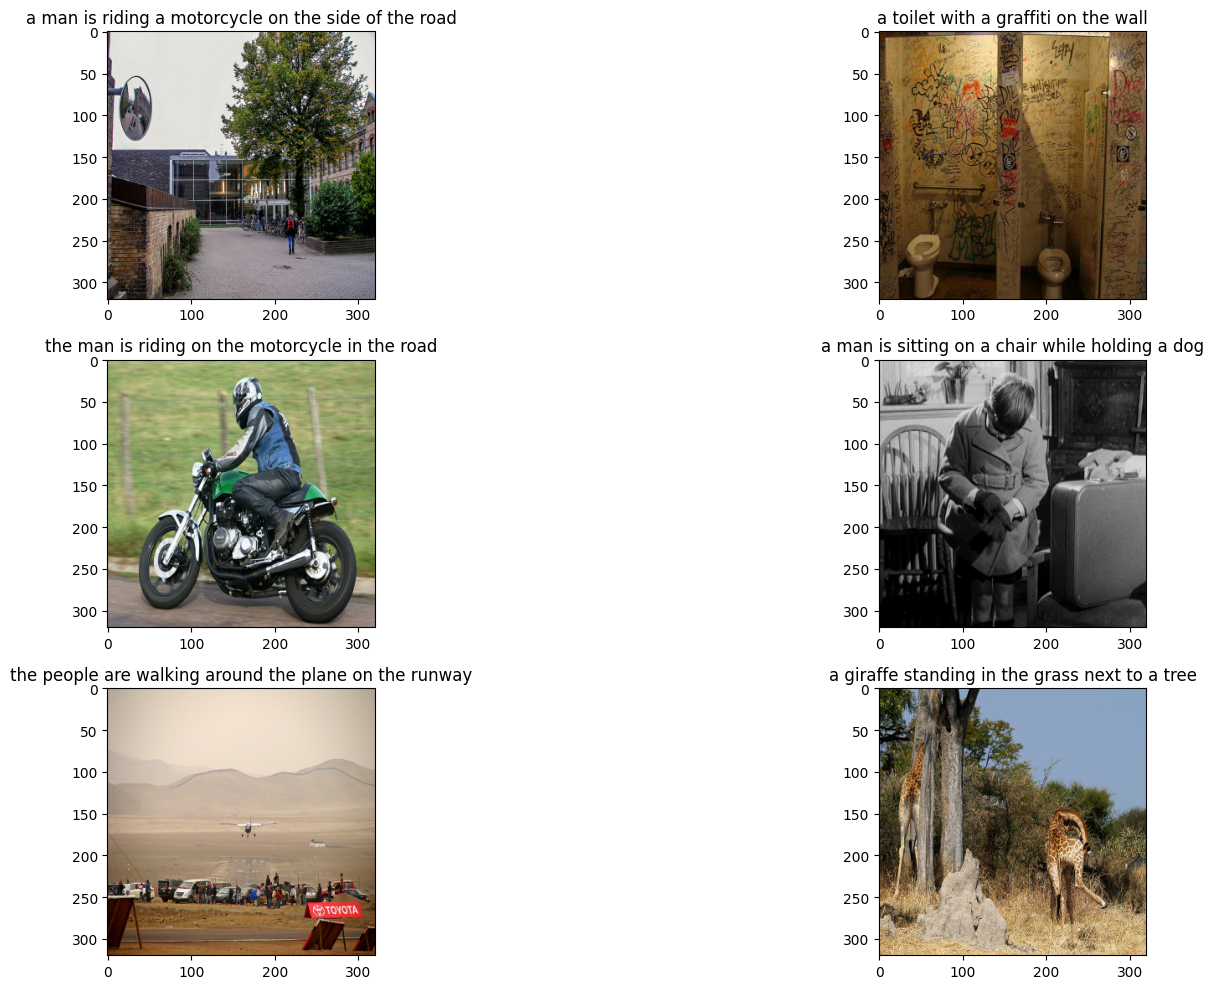

In [63]:
test_images_no = 6
columns = 2
rows = int(test_images_no / columns)
imgs_list, predictions_list = test_and_evaluate(test_images_no)
fig = plt.figure(figsize=(20, 10))
for i,prediction in enumerate(predictions_list):
    fig.add_subplot(rows,columns,i+1)
    plt.imshow(imgs_list[i])
    plt.title(predictions_list[i])
plt.tight_layout()
plt.show()  # Display the plot

**Plot loss and accuracy graphs:**

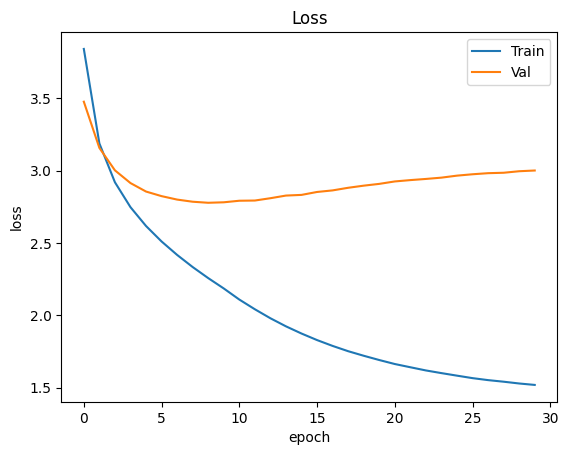

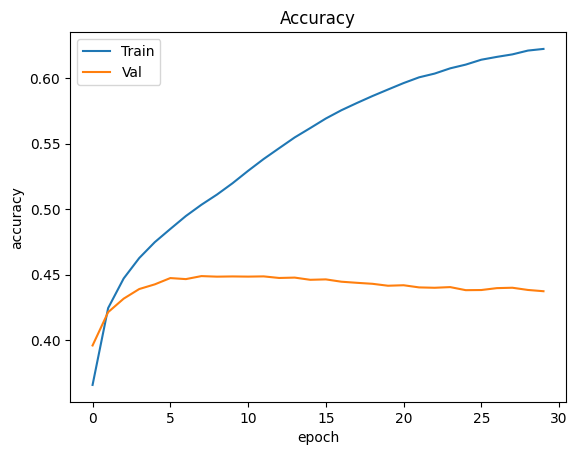

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.show()

plt.plot(history.history['masked_acc'])
plt.plot(history.history['val_masked_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Val'])
plt.show()

In [44]:
tf.keras.backend.clear_session()

In [31]:
def test_and_evaluate(test_images_count):
  counter = 0
  test_images = []
  test_captions = []
  predictions_string = []
  predictions_list = []
  imgs_list = []
  bleu_1 = []
  bleu_2 = []
  bleu_3 = []
  bleu_4 = []

  for ex_path, ex_captions in val_data.take(test_images_count*5):
    counter = counter +1
    if counter % 5 == 0: # one image for every 5 captions
      test_img = preprocess_image((ex_path.numpy().decode("utf-8")))[tf.newaxis, :]
      test_images.append(tf.squeeze(test_img))
    caption = ex_captions.numpy().decode("utf-8").split()
    test_captions.append(caption)

  for image in test_images:
      prediction, prediction_string = model.inference(image, temperature=0)
      img = image / 255.0
      predictions_list.append(prediction)
      predictions_string.append(prediction_string)
      imgs_list.append(img)

  for i in range(0,len(predictions_string)):
    score = 0
    y_pred = predictions_string[i]
    y_true = test_captions[i*5 : (i+1)*5]
    print(f"Image {i+1} BLEU scores: ")
    score = sentence_bleu(y_true, y_pred, weights=(1.0,0,0,0))
    bleu_1.append(score)
    print(f"BLEU-1 score: {score}")
    score = sentence_bleu(y_true, y_pred, weights=(0.5,0.5,0,0))
    bleu_2.append(score)
    print(f"BLEU-2 score: {score}")
    score = sentence_bleu(y_true, y_pred, weights=(0.3,0.3,0.3,0))
    bleu_3.append(score)
    print(f"BLEU-3 score: {score}")
    score = sentence_bleu(y_true, y_pred, weights=(0.25,0.25,0.25,0.25))
    bleu_4.append(score)
    print(f"BLEU-4 score: {score}")
  print(f' Average BLEU 1 : {np.mean(bleu_1)} \t Average BLEU 2 :{np.mean(bleu_2)}\t Average BLEU 3 :{np.mean(bleu_3)}\t Average BLEU 4 :{np.mean(bleu_4)}')
  return imgs_list, predictions_list
test_images_no = 200
imgs_list, predictions_list = test_and_evaluate(test_images_no)

Image 1 BLEU scores: 
BLEU-1 score: 0.6363636363636364
BLEU-2 score: 0.43693144875265144
BLEU-3 score: 3.0792951098244857e-93
BLEU-4 score: 9.860044343608264e-155
Image 2 BLEU scores: 
BLEU-1 score: 0.4
BLEU-2 score: 0.36514837167011077
BLEU-3 score: 0.36046543250433827
BLEU-4 score: 0.2626909894424158
Image 3 BLEU scores: 
BLEU-1 score: 0.7777777777777778
BLEU-2 score: 0.3118047822311618
BLEU-3 score: 2.5149710631476116e-93
BLEU-4 score: 8.329397756741367e-155
Image 4 BLEU scores: 
BLEU-1 score: 0.6
BLEU-2 score: 0.36514837167011066
BLEU-3 score: 0.2927889113552356
BLEU-4 score: 4.38832006142665e-78
Image 5 BLEU scores: 
BLEU-1 score: 0.75
BLEU-2 score: 0.46291004988627577
BLEU-3 score: 3.18787508243652e-93
BLEU-4 score: 1.0148936155293581e-154
Image 6 BLEU scores: 
BLEU-1 score: 1.0
BLEU-2 score: 0.9258200997725514
BLEU-3 score: 0.6867198272427282
BLEU-4 score: 8.929334592065812e-78
Image 7 BLEU scores: 
BLEU-1 score: 0.45454545454545453
BLEU-2 score: 0.21320071635561047
BLEU-3 score

c:\Users\asifk\Documents\NLP\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\asifk\Documents\NLP\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\asifk\Documents\NLP\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us